In [1]:
import pandas as pd
import sqlite3
import numpy as np
from IPython.display import Image

# Вспомогательные функции

## Вывод фиксированного колва знаков после запятой

In [2]:
def toFixed(numObj, digits=0):
    return(f"{numObj:.{digits}}")

# Скачаем данные из БД

## Подключимся к БД

In [3]:
conn = sqlite3.connect('Заказы покупателей БД.db')  # Подключимся к БД
cur = conn.cursor()  # Получим объект курсор

## Текст запроса к БД

In [4]:
q = 'select * from Zakaz'

## Получим данные

In [5]:
data = pd.read_sql(q, conn)

# Преобразование data

## Обработка имеющихся данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166875 entries, 0 to 166874
Data columns (total 14 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   ЗаказКлиентаСсылка                       166875 non-null  object
 1   ЗаказКлиентаДата                         166875 non-null  object
 2   ЗаказКлиентаПартнерКод                   166875 non-null  object
 3   ЗаказКлиентаПартнер                      166875 non-null  object
 4   ЗаказКлиентаПартнерБизнесРегион          166875 non-null  object
 5   ЗаказКлиентаПартнерОсновнойМенеджер      166875 non-null  object
 6   ЗаказКлиентаСуммаДокумента               166875 non-null  object
 7   ЗаказКлиентаСтатус                       166875 non-null  object
 8   ЗаказКлиентаНоменклатураКод              166875 non-null  object
 9   ЗаказКлиентаНоменклатура                 166875 non-null  object
 10  ЗаказКлиентаНоменклатураВидНоменклатуры  166

### Преобразуем to_datetime

In [7]:
data['ЗаказКлиентаДата'] = pd.to_datetime(data['ЗаказКлиентаДата'], yearfirst=True, exact=True, format='%Y-%m-%d')

### Преобразуем to_numeric

In [8]:
data['ЗаказКлиентаСуммаДокумента'] = pd.to_numeric(data['ЗаказКлиентаСуммаДокумента'])
data['ЗаказКлиентаКоличество'] = pd.to_numeric(data['ЗаказКлиентаКоличество'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166875 entries, 0 to 166874
Data columns (total 14 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   ЗаказКлиентаСсылка                       166875 non-null  object        
 1   ЗаказКлиентаДата                         166875 non-null  datetime64[ns]
 2   ЗаказКлиентаПартнерКод                   166875 non-null  object        
 3   ЗаказКлиентаПартнер                      166875 non-null  object        
 4   ЗаказКлиентаПартнерБизнесРегион          166875 non-null  object        
 5   ЗаказКлиентаПартнерОсновнойМенеджер      166875 non-null  object        
 6   ЗаказКлиентаСуммаДокумента               166875 non-null  float64       
 7   ЗаказКлиентаСтатус                       166875 non-null  object        
 8   ЗаказКлиентаНоменклатураКод              166875 non-null  object        
 9   ЗаказКлиентаНоменклатура  

### Удалим заказы в статусах на "На согласовании" и "К выполнению / В резерве"

In [10]:
data.drop(index = data.loc[data['ЗаказКлиентаСтатус'] == 'На согласовании'].index, axis = 0, inplace=True)
data.drop(index = data.loc[data['ЗаказКлиентаСтатус'] == 'К выполнению / В резерве'].index, axis = 0, inplace=True)

In [11]:
data.reset_index(inplace=True) #сбросим имеющиеся индексы и воссоздадим по порядку заново
del data['index']

## Добавим новые метрики

### Добавим метрику растояний

In [12]:
otNovosibirska = {'Адыгея Респ':4000, 'Акмолинская область':1200, 'Актюбинская область':2400, 'Алматинская область':1800, 'Алтай Респ':450,
     'Алтайский край':230, 'Амурская обл':4300, 'Архангельская обл':3300, 'Астраханская обл':3600, 'Астрахань':3600, 'Атырауская область':2800,
     'Барнаул':230, 'Башкортостан Респ':2000, 'Белгород':3600, 'Белгородская обл':3600, 'Бишкек':2000, 'Благовещенск':4300,
     'Брянская обл':3700, 'Бурятия Респ':2300, 'Владимирская обл':3200, 'Волгоградская обл':3200, 'Вологодская обл':3000, 'Воронежская обл':3300,
     'Восточно-Казахстанская область':740, 'Дальневосточный ФО':None, 'Еврейская Аобл':4700, 'Екатеринбург':6400, 'Иркутская обл':1800,
     'Казань':2500, 'Казахстан':None, 'Калининградская обл':None, 'Калужская обл':3600, 'Камчатская обл':None, 'Карагандинская область':1000,
     'Кемерово':260, 'Кемеровская обл':260, 'Кировская обл':2500, 'Коми Респ':3200, 'Краснодар':4000, 'Краснодарский край':4000,
     'Красноярск':790, 'Красноярский край':790, 'Курганская обл':1200, 'Кызылординская область':2000, 'Ленинградская обл':4000,
     'Липецкая обл':3300, 'МОНГОЛИЯ':2700, 'Магаданская обл':6700, 'Мангистауская область':3400, 'Марий Эл Респ':2700, 'Мордовия Респ':2900,
     'Москва':3400, 'Московская обл':3400, 'Мурманск':4600, 'Мурманская обл':4600, 'Ненецкий АО':3900, 'Нижегородская обл':3000,
     'Новокузнецк':370, 'Новосибирск':1, 'Новосибирская обл':1, 'Омская обл':650, 'Оренбург':2300, 'Оренбургская обл':2300,
     'Орловская обл':3500, 'Павлодарская обл':670, 'Пензенская обл':2900, 'Пермская обл':2000, 'Пермь':2000, 'Петрозаводск':3900,
     'Приволжский ФО':None, 'Приморский край':3500, 'Республика Крым':4400, 'Ростов-на-Дону':3700, 'Ростовская обл':3700,
     'Рязанская обл':3300, 'Рязань':3300, 'Самарская обл':2400, 'Санкт-Петербург':3900, 'Саратовская обл':2800, 'Саха /Якутия/ Респ':5000,
     'Сахалинская обл':6100, 'Свердловская обл':1700, 'Северо-Западный ФО':None, 'Северо-Казахстанская область':930, 'Сибирский ФО':None,
     'Смоленская обл':3700, 'Ставрополь':3800, 'Ставропольский край':3800, 'Таймырский АО':2700, 'Тамбовская обл':3100, 'Татарстан Респ':2400,
     'Теркестанская обл':None, 'Томская обл':900, 'Тульская обл':3500, 'Тыва Респ':1300, 'Тюменская обл':1300, 'Удмуртская Респ':2300,
     'Ульяновская обл':2700, 'Уральский ФО':None, 'Хабаровский край':5000, 'Хакасия Респ':1000, 'Ханты-Мансийский - Югра АО':1800,
     'Химки':3400, 'Центральный ФО':None, 'Челябинск':1600, 'Челябинская обл':1600, 'Читинская обл':2800, 'Чувашская - Чувашия Респ':2700,
     'Чукотский АО':None, 'Южно-Сахалинск':5900, 'Якутск':5000, 'Ямало-Ненецкий АО':2600, 'Ярославская обл':3200}
    
    # добавим данные о растоянии в DF
data['RastoynieOtNSK'] = None
for number, series in data.iterrows():
    data.at[number, "RastoynieOtNSK"] = otNovosibirska.get(series['ЗаказКлиентаПартнерБизнесРегион'])

### Метрика свойств

In [13]:
# добавим новый столбец
data['Svoystvo'] = 'Не определено'

#### Процедура замены

In [14]:
def changing(data, svoystvo):
    for elem in list_nomenklatura:
        IndexIzmenit = data.loc[data['ЗаказКлиентаНоменклатура'] == elem].index
        data.loc[IndexIzmenit, 'Svoystvo'] = svoystvo

#### Шкаф 310

In [15]:
list_nomenklatura = ['310 ШП-К1 (Н) ЗБ - Евро', '310 ШП-К1 (Н) ОБ - Евро', '310 ШП-К1 (Н) ОБ -Замок',
                     '310 ШП-К1 (Н)ЗК - Евро', '310 ШП-К1 (Н)ЗК -Замок', '310 ШП-К1 (Н)ОК - Евро',
                     '310 ШП-К1 (Н)ОК -Замок', '310 ШП-К1 (Н) ЗБ -Замок', '310Э ШП-К1 (Н)ЗК -Замок',
                     '310Э ШП-К1 (Н)ОК -Замок', '310Э ШП-К1 (Н) ОБ -Замок', '310Э ШП-К1 (Н) ЗБ -Замок',
                     '310Э ШП-К1 (Н) ОБ -Евро', '310Э ШП-К1 (Н)ЗК -Евро', '310Э ШП-К1 (Н)ОК -Евро',
                     '310 ШП-К1 НЕ СТАНДАРТ', '310Э ШП-К1 (Н) ЗБ - Евро'
                     ]

In [16]:
changing(data, '310')

#### Шкаф 315

In [17]:
list_nomenklatura = ['315 ШП-К1-О1 (Н) ЗБ -Замок', '315 ШП-К1-О1 (Н) ОБ - Евро', '315 ШП-К1-О1 (Н) ОБ -Замок',
                     '315 ШП-К1-О1 (Н)ЗК - Евро', '315 ШП-К1-О1 (Н)ЗК -Замок', '315 ШП-К1-О1 (Н)ОК - Евро',
                     '315 ШП-К1-О1 (Н)ОК -Замок', '315 ШП-К1-О1 НЕ СТАНДАРТ', '315Э ШП-К1-О1 (Н) ЗБ - Евро',
                     '315Э ШП-К1-О1 (Н) ЗБ -Замок', '315Э ШП-К1-О1 (Н) ОБ - Евро', '315Э ШП-К1-О1 (Н) ОБ -Замок',
                     '315Э ШП-К1-О1 (Н)ЗК - Евро', '315Э ШП-К1-О1 (Н)ЗК -Замок', '315Э ШП-К1-О1 (Н)ОК - Евро',
                     '315Э ШП-К1-О1 (Н)ОК -Замок', '315 ШП-К1-О1 (Н) ЗБ - Евро'
                     ]

In [18]:
changing(data, '315')

#### Шкаф 320

In [19]:
list_nomenklatura = ['320 ШП-К1-О2 (Н) ЗБ - Евро', '320 ШП-К1-О2 (Н) ЗБ -Замок', '320 ШП-К1-О2 (Н) ОБ - Евро',
                     '320 ШП-К1-О2 (Н) ОБ -Замок', '320 ШП-К1-О2 (Н)ЗК - Евро', '320 ШП-К1-О2 (Н)ЗК -Замок',
                     '320 ШП-К1-О2 (Н)ОК - Евро', '320 ШП-К1-О2 (Н)ОК -Замок', '320 ШП-К1-О2 НЕ СТАНДАРТ',
                     '320Э ШП-К1-О2 (Н) ЗБ - Евро', '320Э ШП-К1-О2 (Н) ЗБ -Замок', '320Э ШП-К1-О2 (Н) ОБ - Евро',
                     '320Э ШП-К1-О2 (Н) ОБ -Замок', '320Э ШП-К1-О2 (Н)ЗК - Евро', '320Э ШП-К1-О2 (Н)ЗК -Замок',
                     '320Э ШП-К1-О2 (Н)ОК - Евро', '320Э ШП-К1-О2 (Н)ОК -Замок'
                     ]

In [20]:
changing(data, '320')

#### Шкаф 321

In [21]:
list_nomenklatura = ['3201 ШП-К2 (Н) ЗБ - Евро', '3201 ШП-К2 (Н) ЗБ -Замок', '3201 ШП-К2 (Н) ОБ - Евро',
                     '3201 ШП-К2 (Н) ОБ -Замок', '3201 ШП-К2 (Н)ЗК - Евро', '3201 ШП-К2 (Н)ЗК -Замок',
                     '3201 ШП-К2 (Н)ОК - Евро', '3201 ШП-К2 (Н)ОК -Замок', '3201 ШП-К2 НЕ СТАНДАРТ',
                     '3201Э ШП-К2 (Н) ЗБ - Евро', '3201Э ШП-К2 (Н) ЗБ -Замок', '3201Э ШП-К2 (Н) ОБ - Евро',
                     '3201Э ШП-К2 (Н) ОБ -Замок', '3201Э ШП-К2 (Н)ЗК - Евро', '3201Э ШП-К2 (Н)ЗК -Замок',
                     '3201Э ШП-К2 (Н)ОК - Евро', '3201Э ШП-К2 (Н)ОК -Замок'
                     ]

In [22]:
changing(data, '321')

#### Классик + Сибтекс 50

In [23]:
list_nomenklatura = [
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50А, РС-50.01А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50АП',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50АП, РС-50.01А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50АП, РС-50.01П',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50П',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50П, РС-50.01А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50П, РС-50.01П',
    'Сибтекс РПК-В/Н-50-1,0-У1',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А, РС-50',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А, РС-50.01А',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А, РС-50.01П',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50АП',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50АП, РС-50.01А',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50АП, РС-50.01П',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50П',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50П, РС-50.01П',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс"'
]

In [24]:
changing(data, 'рукав ПК')

#### Классик + Сибтекс 65

In [25]:
list_nomenklatura = [
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1 "Сибтекс"',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65А',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65А, РС-65.01А',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65А, РС-65.01П',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65АП',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65АП, РС-65.01А',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65АП, РС-65.01П',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65П',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65П, РС-65.01П',
    'Рукав пожарный напорный РПК-В/Н-65-1,0-У1 "Сибтекс"',
    'Рукав пожарный напорный РПК-В/Н-65-1,0-У1 "Сибтекс" в сборе с ГР-65А'
]

In [26]:
changing(data, 'рукав ПК')

#### Клапана в ассортименте

In [27]:
list_nomenklatura = [
    'Вентиль чугунный фл. 15кч19п Ду 50 Ру 16',
    'Клапан ДУ-50 прямой латунный 15Б3Р (НЗГА) М-М',
    'Клапан ДУ-50 прямой латунный 15Б3Р М-М',
    'Клапан ДУ-50 прямой латунный 15Б3Р М-Ц',
    'Клапан пожарного крана КПК-50 (чугун, Ц-Ц, угловой, 125 град)',
    'Клапан пожарного крана КПК-Ч-50 (чугун, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПК-Ч-50 (чугун, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПК-Ч-65 (чугун, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПК-Ч-65 (чугун, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-М, прямой, 180 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-Ц, угловой, 90 град.)',
    'Клапан пожарного крана КПЛ-65 (латунь, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПЛ-65 (латунь, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПЛ-65 (латунь, М-Ц, угловой, 90 град.)',
    'Клапан пожарный РПТК 50 (чугун, М-Ц, угловой, 120 град)',
    'Клапан пожарный РПТК 65 (чугун, М-Ц, угловой, 120 град)',
    'Вентиль чугунный  D50 (15кч11р) М-Ц'
]

In [28]:
changing(data, 'Клапан для ПК')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162519 entries, 0 to 162518
Data columns (total 16 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   ЗаказКлиентаСсылка                       162519 non-null  object        
 1   ЗаказКлиентаДата                         162519 non-null  datetime64[ns]
 2   ЗаказКлиентаПартнерКод                   162519 non-null  object        
 3   ЗаказКлиентаПартнер                      162519 non-null  object        
 4   ЗаказКлиентаПартнерБизнесРегион          162519 non-null  object        
 5   ЗаказКлиентаПартнерОсновнойМенеджер      162519 non-null  object        
 6   ЗаказКлиентаСуммаДокумента               162519 non-null  float64       
 7   ЗаказКлиентаСтатус                       162519 non-null  object        
 8   ЗаказКлиентаНоменклатураКод              162519 non-null  object        
 9   ЗаказКлиентаНоменклатура  

# Анализ Наборов

## Функции

In [30]:
def make_df(array, columns, index):
    df = pd.DataFrame(data=array, columns=columns,index=index)
#    df['Описание'] = df.index
    return(df)

In [31]:
def raschet(data, key_1, key_2, key_3, route='full'):
    if route == 'Да':
        data = data.loc[data['ЗаказКлиентаОтменено'] == route]
    elif route == 'Нет':
        data = data.loc[data['ЗаказКлиентаОтменено'] == route]

    grouped = data.groupby('Svoystvo')  # Сгруппируем по признаку

    # Получим кол-во документов по X
#    X = grouped.get_group(key_1)['ЗаказКлиентаСсылка'].unique()
    X = data.loc[data['Svoystvo'] == key_1]['ЗаказКлиентаСсылка'].unique()
    if len(X) == 0:
            return(0)
    # Получим соотношение документов с X от документов всего
    Support_X = len(X) / len(data["ЗаказКлиентаСсылка"].unique())

    # Считаем сумму документов по пересечению документов
    if key_3 is not None:
        X_X = data.loc[data['Svoystvo'] == key_3]['ЗаказКлиентаСсылка'].unique()
#        X_X = grouped.get_group(key_3)['ЗаказКлиентаСсылка'].unique()
        X_1_3 = set(X) & set(X_X)
        # Мы всегда можем переписывать значения, т.к. если key_3 None
        # то неважно переписали значения или нет
        if len(X_1_3) == 0:
            return(0)
        Support_X = len(X_1_3) / len(data["ЗаказКлиентаСсылка"].unique())
        X = list(X_1_3)

    # Получим кол-во документов по Y
#    Y = grouped.get_group(key_2)['ЗаказКлиентаСсылка'].unique()
    Y = data.loc[data['Svoystvo'] == key_2]['ЗаказКлиентаСсылка'].unique()
    # Получим соотношение документов с Y от документов всего
    
    if len(Y) == 0:
        return(0)
    Support_Y = len(Y) / len(data["ЗаказКлиентаСсылка"].unique())

    # Получим пересение списков, т.е. перечень документов имеющихся в обоих частях
    Y_X = set(Y) & set(X)
    
    if len(Y_X) == 0:
        return(0)
    
    # Получим соотношение документов с XY от документов всего
    Support_X_Y = len(Y_X)/len(data["ЗаказКлиентаСсылка"].unique())
    # Получим шанс продать Y если уже есть интерес к X
    Confidence = Support_X_Y/Support_X

    new_array = np.array([[len(data["ЗаказКлиентаСсылка"].unique()), 100],
                          [len(X), toFixed(Support_X*100, 4)],
                          [Y.shape[0], toFixed(Support_Y*100, 4)],
                          [len(Y_X), toFixed(Support_X_Y*100, 4)],
                          ['', toFixed(Confidence*100, 4)],
                          ['', '']
                          ])

    return(new_array)

## Анализ по всем заказам (отмененным и сработанным)

### 310 + рукав для ПК

In [32]:
new_array = raschet(data, '310', 'рукав ПК', None, route='full')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_full_1 = make_df(new_array, columns, index)

### 310 + Клапан для ПК

In [33]:
new_array = raschet(data, '310', 'Клапан для ПК', None, route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_full_2 = make_df(new_array, columns, index)

### 310 и  Рукав для ПК + Клапан для ПК

In [34]:
new_array = raschet(data, '310', 'Клапан для ПК', 'рукав ПК', route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_full_3 = make_df(new_array, columns, index)

### Склеим df

In [35]:
df_finaly_full = pd.concat([df_full_1, df_full_2, df_full_3])
# df_finaly_full

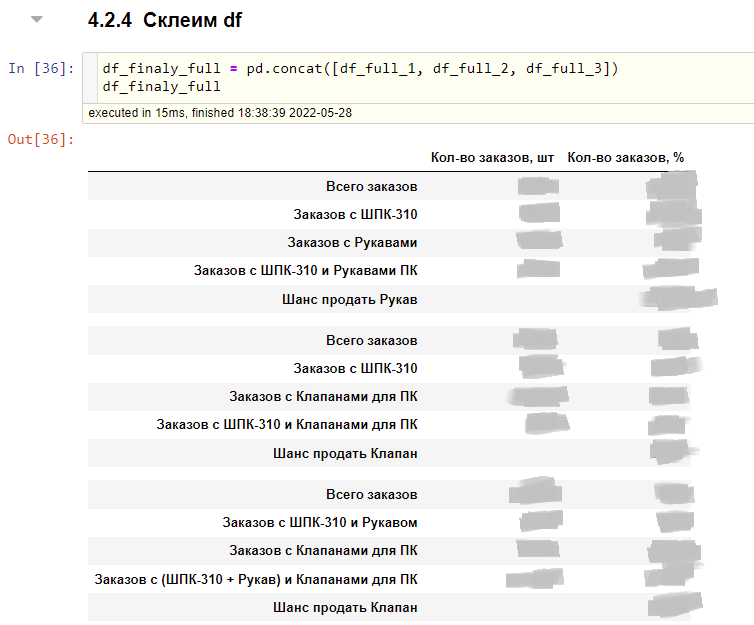

In [36]:
Image("11.png")

## Анализ по проданным заказам

### 310 + рукав для ПК

In [37]:
new_array = raschet(data, '310', 'рукав ПК', None, route='Да')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_yes_1 = make_df(new_array, columns, index)

### 310 + клапан для ПК

In [38]:
new_array = raschet(data, '310', 'Клапан для ПК', None, route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_yes_2 = make_df(new_array, columns, index)

### (310 и рукав для ПК) + клапан для ПК

In [39]:
new_array = raschet(data, '310', 'Клапан для ПК', 'рукав ПК', route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_yes_3 = make_df(new_array, columns, index)

### Склеим df

In [40]:
df_finaly_yes = pd.concat([df_yes_1, df_yes_2, df_yes_3])
# df_finaly_yes

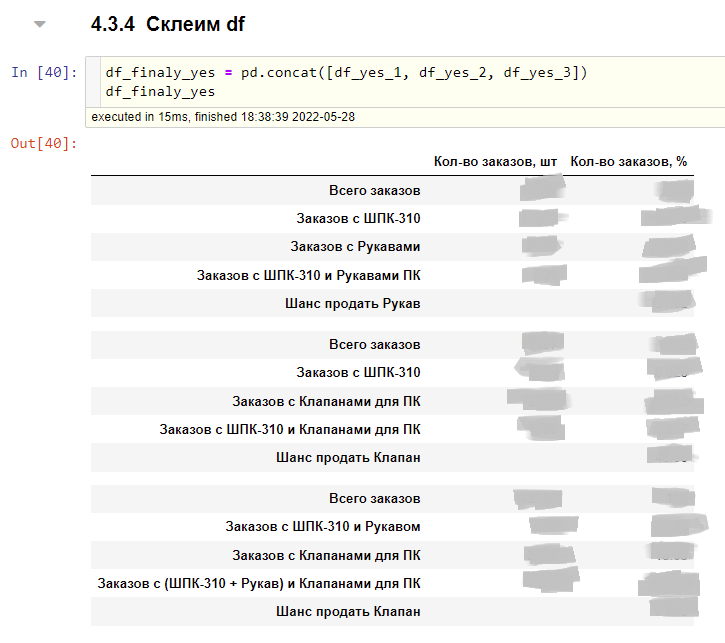

In [41]:
Image("12.png")

## Анализ по отмененным заказам

### 310 + рукав для ПК

In [42]:
new_array = raschet(data, '310', 'рукав ПК', None, route='Нет')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_no_1 = make_df(new_array, columns, index)

### 310 + клапан для ПК

In [43]:
new_array = raschet(data, '310', 'Клапан для ПК', None, route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_no_2 = make_df(new_array, columns, index)

### (310 и рукав для ПК) + клапан для ПК

In [44]:
new_array = raschet(data, '310', 'Клапан для ПК', 'рукав ПК', route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_no_3 = make_df(new_array, columns, index)

### Склеим df

In [45]:
df_finaly_no = pd.concat([df_no_1, df_no_1, df_no_1])
# df_finaly_no

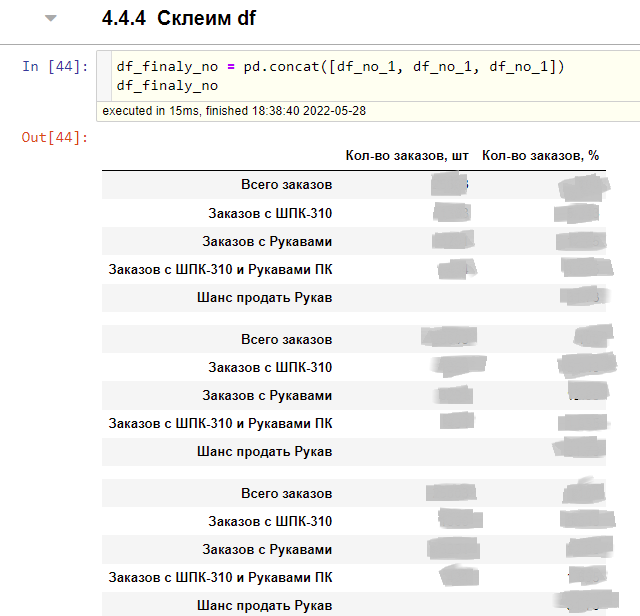

In [46]:
Image("13.png")

## Склеим данные 3-х фильтров

In [47]:
frame = np.concatenate((df_finaly_full.values, df_finaly_yes.values, df_finaly_no.values), axis=1)

In [48]:
columns = ['Кол-во заказов, шт','Кол-во заказов, %','Кол-во заказов, шт','Кол-во заказов, %','Кол-во заказов, шт','Кол-во заказов, %']

In [49]:
columns = [
    np.array([
        'Все заказы', 'Все заказы', 'Сработанные заказы', 'Сработанные заказы',
        'Закрытые заказы', 'Закрытые заказы'
    ]),
    np.array([
        'Кол-во заказов, шт', 'Кол-во заказов, %', 'Кол-во заказов, шт',
        'Кол-во заказов, %', 'Кол-во заказов, шт', 'Кол-во заказов, %'
    ])
]

In [50]:
df_finaly_all = pd.DataFrame(data = frame, index = df_finaly_full.index, columns = columns)

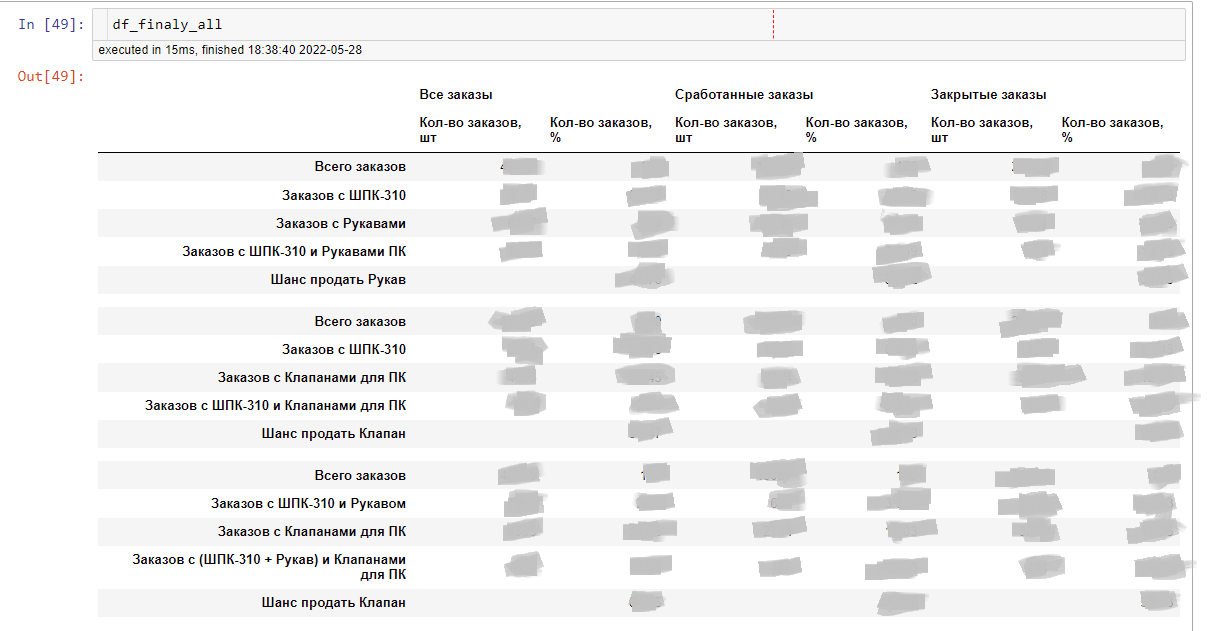

In [51]:
Image("14.png")

# Анализ с разбивкой по удаленности региона

## Ближе 200 км

### Анализ по всем заказам

In [52]:
data_filter = data.loc[data['RastoynieOtNSK'] <= 200]

In [53]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='full')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_full_1 = make_df(new_array, columns, index)

In [54]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_full_2 = make_df(new_array, columns, index)

In [55]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_full_3 = make_df(new_array, columns, index)

In [56]:
df_finaly_full = pd.concat([df_full_1, df_full_2, df_full_3])

### Анализ по проданным заказам

In [57]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Да')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_yes_1 = make_df(new_array, columns, index)

In [58]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_yes_2 = make_df(new_array, columns, index)

In [59]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_yes_3 = make_df(new_array, columns, index)

In [60]:
df_finaly_yes = pd.concat([df_yes_1, df_yes_2, df_yes_3])

### Анализ по отказам

In [61]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Нет')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_no_1 = make_df(new_array, columns, index)

In [62]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_no_2 = make_df(new_array, columns, index)

In [63]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_no_3 = make_df(new_array, columns, index)

In [64]:
df_finaly_no = pd.concat([df_no_1, df_no_2, df_no_3])

### Склеим данные по 3 анализам

In [65]:
frame = np.concatenate((df_finaly_full.values, df_finaly_yes.values, df_finaly_no.values), axis=1)

In [66]:
columns = ['Кол-во заказов, шт','Кол-во заказов, %','Кол-во заказов, шт','Кол-во заказов, %','Кол-во заказов, шт','Кол-во заказов, %']

In [67]:
columns = [
    np.array([
        'Все заказы', 'Все заказы', 'Сработанные заказы', 'Сработанные заказы',
        'Закрытые заказы', 'Закрытые заказы'
    ]),
    np.array([
        'Кол-во заказов, шт', 'Кол-во заказов, %', 'Кол-во заказов, шт',
        'Кол-во заказов, %', 'Кол-во заказов, шт', 'Кол-во заказов, %'
    ])
]

In [68]:
df_finaly_all = pd.DataFrame(data = frame, index = df_finaly_full.index, columns = columns)
#df_finaly_all

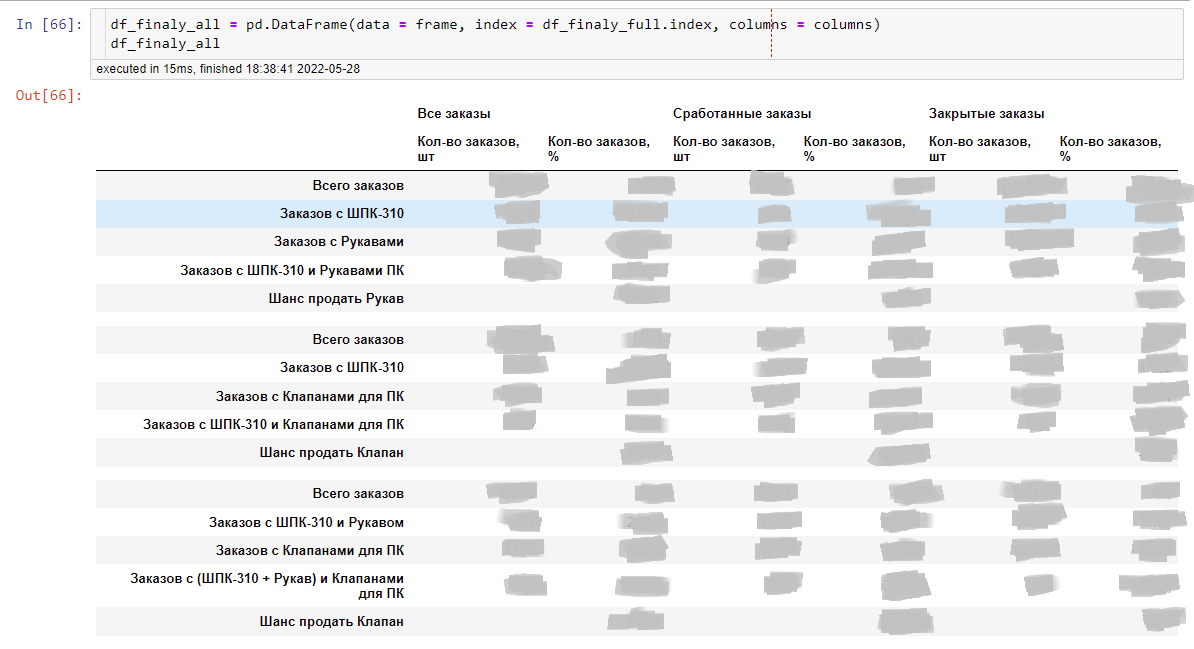

In [69]:
Image("15.png")

## От 200 до 800 км

In [70]:
data_filter = data.loc[(data['RastoynieOtNSK'] > 200) & (data['RastoynieOtNSK'] <= 800)]

### Анализ по всем заказам

In [71]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='full')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_full_1 = make_df(new_array, columns, index)

In [72]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_full_2 = make_df(new_array, columns, index)

In [73]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_full_3 = make_df(new_array, columns, index)

In [74]:
df_finaly_full = pd.concat([df_full_1, df_full_2, df_full_3])

### Анализ по проданным заказам

In [75]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Да')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_yes_1 = make_df(new_array, columns, index)

In [76]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_yes_2 = make_df(new_array, columns, index)

In [77]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_yes_3 = make_df(new_array, columns, index)

In [78]:
df_finaly_yes = pd.concat([df_yes_1, df_yes_2, df_yes_3])

### Анализ по отказам

In [79]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Нет')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_no_1 = make_df(new_array, columns, index)

In [80]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_no_2 = make_df(new_array, columns, index)

In [81]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_no_3 = make_df(new_array, columns, index)

In [82]:
df_finaly_no = pd.concat([df_no_1, df_no_2, df_no_3])

### Склеим данные по 3 анализам

In [83]:
frame = np.concatenate((df_finaly_full.values, df_finaly_yes.values, df_finaly_no.values), axis=1)

In [84]:
columns = [
    np.array([
        'Все заказы', 'Все заказы', 'Сработанные заказы', 'Сработанные заказы',
        'Закрытые заказы', 'Закрытые заказы'
    ]),
    np.array([
        'Кол-во заказов, шт', 'Кол-во заказов, %', 'Кол-во заказов, шт',
        'Кол-во заказов, %', 'Кол-во заказов, шт', 'Кол-во заказов, %'
    ])
]

In [85]:
df_finaly_all = pd.DataFrame(data = frame, index = df_finaly_full.index, columns = columns)
# df_finaly_all

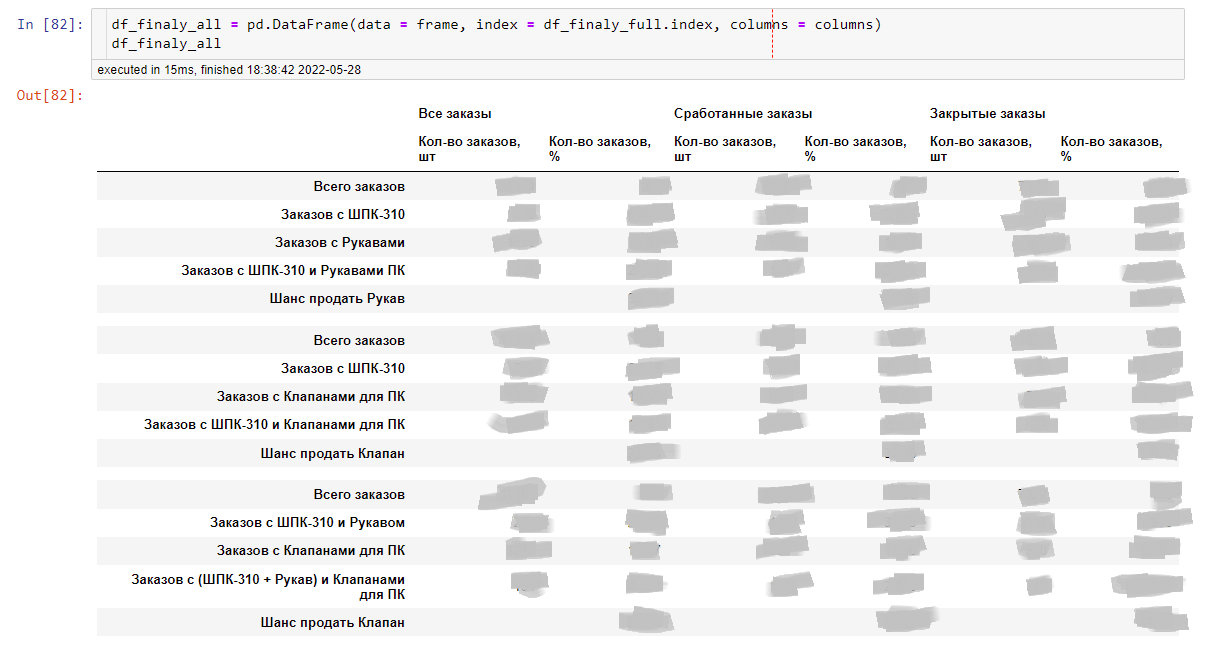

In [86]:
Image("16.png")

## от 800 км

In [87]:
data_filter = data.loc[data['RastoynieOtNSK'] > 800]

### Анализ по всем заказам

In [88]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='full')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_full_1 = make_df(new_array, columns, index)

In [89]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_full_2 = make_df(new_array, columns, index)

In [90]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='full')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_full_3 = make_df(new_array, columns, index)

In [91]:
df_finaly_full = pd.concat([df_full_1, df_full_2, df_full_3])

### Анализ по проданным заказам

In [92]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Да')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_yes_1 = make_df(new_array, columns, index)

In [93]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_yes_2 = make_df(new_array, columns, index)

In [94]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Да')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_yes_3 = make_df(new_array, columns, index)

In [95]:
df_finaly_yes = pd.concat([df_yes_1, df_yes_2, df_yes_3])

### Анализ по отказам

In [96]:
new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Нет')

columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Рукавами',
         'Заказов с ШПК-310 и Рукавами ПК',
         'Шанс продать Рукав',
         '']
df_no_1 = make_df(new_array, columns, index)

In [97]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310',
         'Заказов с Клапанами для ПК',
         'Заказов с ШПК-310 и Клапанами для ПК',
         'Шанс продать Клапан',''
        ]
df_no_2 = make_df(new_array, columns, index)

In [98]:
new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Нет')
columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
index = ['Всего заказов',
         'Заказов с ШПК-310 и Рукавом',
         'Заказов с Клапанами для ПК',
         'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
         'Шанс продать Клапан',
         '']
df_no_3 = make_df(new_array, columns, index)

In [99]:
df_finaly_no = pd.concat([df_no_1, df_no_2, df_no_3])

### Склеим данные по 3 анализам

In [100]:
frame = np.concatenate((df_finaly_full.values, df_finaly_yes.values, df_finaly_no.values), axis=1)

In [101]:
columns = [
    np.array([
        'Все заказы', 'Все заказы', 'Сработанные заказы', 'Сработанные заказы',
        'Закрытые заказы', 'Закрытые заказы'
    ]),
    np.array([
        'Кол-во заказов, шт', 'Кол-во заказов, %', 'Кол-во заказов, шт',
        'Кол-во заказов, %', 'Кол-во заказов, шт', 'Кол-во заказов, %'
    ])
]

In [102]:
df_finaly_all = pd.DataFrame(data = frame, index = df_finaly_full.index, columns = columns)
# df_finaly_all

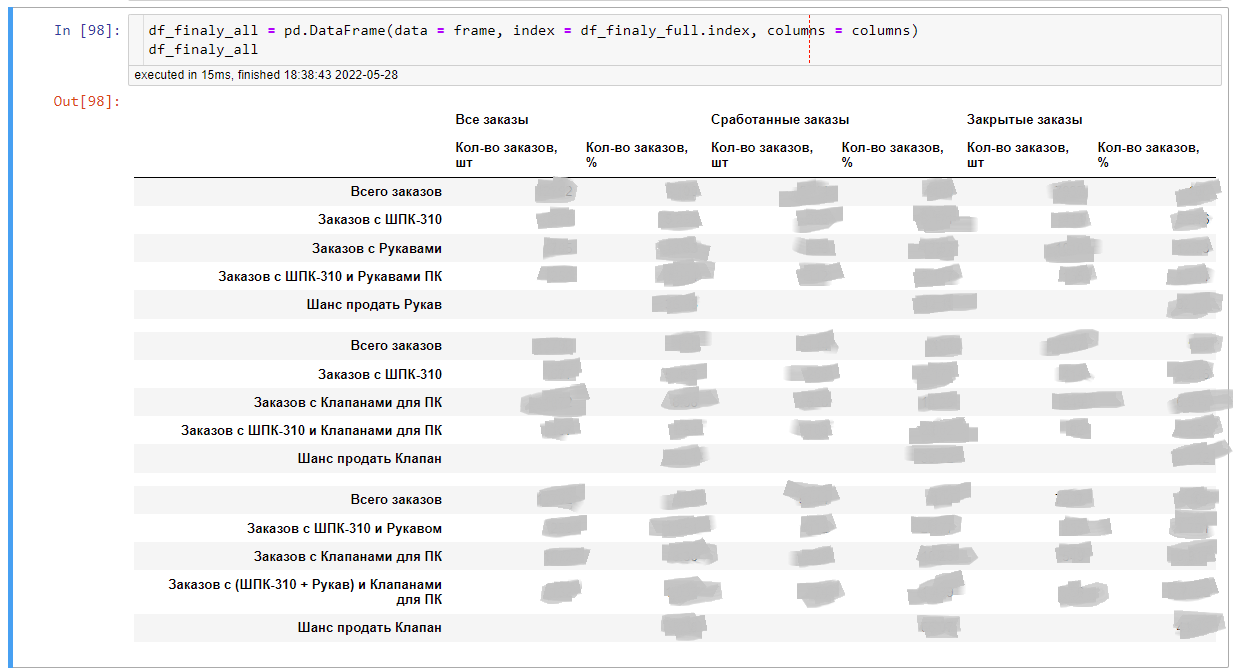

In [103]:
Image("17.png")

# Анализ по регионам

In [104]:
 region = data['ЗаказКлиентаПартнерБизнесРегион'].unique()

In [105]:
def analuse_region(data_filter):
    new_array = raschet(data_filter, '310', 'рукав ПК', None, route='full')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310',
             'Заказов с Рукавами',
             'Заказов с ШПК-310 и Рукавами ПК',
             'Шанс продать Рукав',
             '']
    df_full_1 = make_df(new_array, columns, index)
    #
    new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='full')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310',
             'Заказов с Клапанами для ПК',
             'Заказов с ШПК-310 и Клапанами для ПК',
             'Шанс продать Клапан',''
            ]
    df_full_2 = make_df(new_array, columns, index)
    #
    new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='full')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310 и Рукавом',
             'Заказов с Клапанами для ПК',
             'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
             'Шанс продать Клапан',
             '']
    df_full_3 = make_df(new_array, columns, index)
    #
    #
    df_finaly_full = pd.concat([df_full_1, df_full_2, df_full_3])
    new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Да')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310',
             'Заказов с Рукавами',
             'Заказов с ШПК-310 и Рукавами ПК',
             'Шанс продать Рукав',
             '']
    df_yes_1 = make_df(new_array, columns, index)
    #
    new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Да')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310',
             'Заказов с Клапанами для ПК',
             'Заказов с ШПК-310 и Клапанами для ПК',
             'Шанс продать Клапан',''
            ]
    df_yes_2 = make_df(new_array, columns, index)
    #
    new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Да')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310 и Рукавом',
             'Заказов с Клапанами для ПК',
             'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
             'Шанс продать Клапан',
             '']
    df_yes_3 = make_df(new_array, columns, index)
    #
    df_finaly_yes = pd.concat([df_yes_1, df_yes_2, df_yes_3])
    #
    #
    new_array = raschet(data_filter, '310', 'рукав ПК', None, route='Нет')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310',
             'Заказов с Рукавами',
             'Заказов с ШПК-310 и Рукавами ПК',
             'Шанс продать Рукав',
             '']
    df_no_1 = make_df(new_array, columns, index)
    #
    new_array = raschet(data_filter, '310', 'Клапан для ПК', None, route='Нет')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310',
             'Заказов с Клапанами для ПК',
             'Заказов с ШПК-310 и Клапанами для ПК',
             'Шанс продать Клапан',''
            ]
    df_no_2 = make_df(new_array, columns, index)
    #
    new_array = raschet(data_filter, '310', 'Клапан для ПК', 'рукав ПК', route='Нет')
    columns = ['Кол-во заказов, шт', 'Кол-во заказов, %']
    index = ['Всего заказов',
             'Заказов с ШПК-310 и Рукавом',
             'Заказов с Клапанами для ПК',
             'Заказов с (ШПК-310 + Рукав) и Клапанами для ПК',
             'Шанс продать Клапан',
             '']
    df_no_3 = make_df(new_array, columns, index)
    #
    df_finaly_no = pd.concat([df_no_1, df_no_2, df_no_3])
    #
    #
    frame = np.concatenate((df_finaly_full.values, df_finaly_yes.values, df_finaly_no.values), axis=1)
    columns = [
    np.array([
        'Все заказы', 'Все заказы', 'Сработанные заказы', 'Сработанные заказы',
        'Закрытые заказы', 'Закрытые заказы'
    ]),
    np.array([
        'Кол-во заказов, шт', 'Кол-во заказов, %', 'Кол-во заказов, шт',
        'Кол-во заказов, %', 'Кол-во заказов, шт', 'Кол-во заказов, %'
    ])
    ]
    
    df_finaly_all = pd.DataFrame(data = frame, index = df_finaly_full.index, columns = columns)
    return(df_finaly_all)

In [106]:
list_data = {}
for elem in region:
    time_data = data_filter = data.loc[data['ЗаказКлиентаПартнерБизнесРегион'] == elem]
    #print(f'Регион {elem}')
    list_data[elem] = analuse_region(time_data)
    #print(df_finaly_all)

In [107]:
list_data.keys()

dict_keys(['Новосибирская обл', 'Красноярский край', 'Тюменская обл', 'Павлодарская обл', 'Иркутская обл', 'Алтайский край', 'Кемеровская обл', 'Ханты-Мансийский - Югра АО', 'Сибирский ФО', 'Приморский край', 'Саха /Якутия/ Респ', 'Омская обл', 'Томская обл', 'Хабаровский край', 'Оренбургская обл', '', 'Бурятия Респ', 'Северо-Казахстанская область', 'Московская обл', 'Восточно-Казахстанская область', 'Карагандинская область', 'Акмолинская область', 'Ямало-Ненецкий АО', 'Амурская обл', 'Башкортостан Респ', 'Хакасия Респ', 'Краснодарский край', 'Камчатская обл', 'Алтай Респ', 'Читинская обл', 'Тыва Респ', 'Ленинградская обл', 'Тамбовская обл', 'Сахалинская обл', 'Дальневосточный ФО', 'Липецкая обл', 'Еврейская Аобл', 'Вологодская обл', 'Магаданская обл', 'Свердловская обл', 'Челябинская обл', 'Кировская обл', 'Казахстан', 'Рязанская обл', 'Пермская обл', 'Татарстан Респ', 'Уральский ФО', 'Ростовская обл', 'Ставропольский край', 'Курганская обл', 'Волгоградская обл', 'Чувашская - Чувашия 

In [108]:
# list_data.get('Иркутская обл')

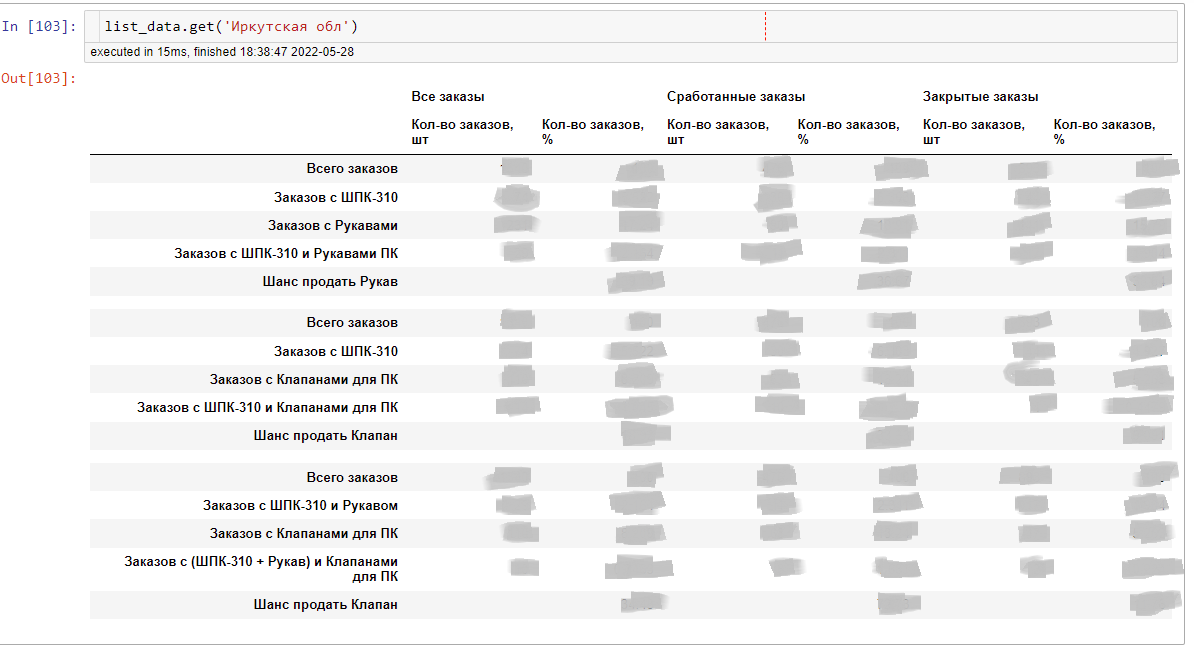

In [109]:
Image("18.png")